<a href="https://colab.research.google.com/github/supu18/test/blob/main/Stock_Price_Prediction_and_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

| Author        | Supriya Jayaraj |
| ------------- | ------------- |
| Matrikelnummer|    5452793  |



---


# Description
This Python code demonstrates financial stock analysis and visualisation utilising a variety of libraries, including <b>yfinance, pandas, seaborn, and PyTorch.</b>  It imports historical price data for equities such as <b>TESLA, META, and AMD</b>, and computes returns and certain indicators.


Based on past data, a neural network model is created to estimate <b>TESLA's</b> returns for the following day. The model with two dense layers is trained over <b> 1000 </b>epochs. Test predictions are created and assessed.
The trained model is used to estimate future prices in multiple steps based on recent data. Plots show how actual prices compare to expected prices.


In addition, <b >sentiment analysis </b> is performed on the most recent news for the equities to generate a sentiment score.

A heatmap represents the <b>correlation analysis</b> of stock prices.


Quadratic optimisation is used to create <b>optimal portfolio weights</b>, which maximise returns while constraining risk.


Various time series plots are created to visually analyse price, volume, returns, and indicators across time. Useful for investigating signals and patterns.


Overall, the code exhibits a comprehensive <b>data science pipeline</b> for <b>financial analysis</b>, including <b>data loading</b>, <b>feature processing</b>, visual analytics</b>,<b><b> predictive modelling with neural networks</b>, <b>model validation</b>, and <b>optimal portfolio creation</b>, <b>sentiment analysis </b>.


---




---



<b>NOTE:</b> This code demonstrates the analysis for 3 comapnies only and taken Germany as the country for predection. It can be expanded based on user's need.





In [ ]:
!pip install ta

In [ ]:
#Importing required libraries
import math
import seaborn as sns
from textblob import TextBlob
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.volume import money_flow_index
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.volume import money_flow_index
from textblob import TextBlob
import yfinance as yf
import cvxpy as cp
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [ ]:
# Set seaborn style
sns.set_theme(style='darkgrid')

COLORBLIND_COLORS = sns.color_palette("colorblind", n_colors=20)
START_DATE = '2022-01-01'
END_DATE = datetime.now()
START_DATE_PREDICTION = '2023-01-02'
END_DATE_PREDICTION = '2023-02-01'
NUM_EPOCHS = 1000  # Train the model
tickers = ['TSLA', 'META', 'AMD']
company_name = ['TESLA', 'META', 'Advanced Micro Devices']
GERMANY_TICKER = '^GDAXI'  # Select Germany-specific stock data (e.g., using DAX index)
RISK_TOLERANCE = 0.1
NUM_EPOCHS = 1000
metrics = ['Volume', 'Daily Return']
NUM_METRICS = len(metrics)
NUM_COMPANIES = len(tickers)
scaler = StandardScaler()

In [ ]:
def get_stock_data(ticker_name, start=START_DATE, end=END_DATE):
    """
    Retrieves stock data for a given ticker symbol and date range.

    Args:
        ticker (str): The ticker symbol of the stock.
        start_date (str): The start date of the data range in the
            format 'YYYY-MM-DD'.
        end_date (str): The end date of the data range in the
            format 'YYYY-MM-DD'.

    Returns:
        pandas.DataFrame: The stock data for the specified ticker
            and date range.
    """
    stock_data = yf.download(ticker_name, start, end)
    return stock_data

In [ ]:
def plot_graphs(title, x_label, y_label):
    """
    Plot graphs with the given title, x-axis label, and y-axis label.

    Parameters:
    title (str): The title of the graph.
    x_label (str): The label for the x-axis.
    y_label (str): The label for the y-axis.
    """
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    # Use bbox_to_anchor with values less than  1 to keep it inside the graph
    plt.legend(loc='upper right', bbox_to_anchor=(0.91, 1.01))
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()

In [ ]:

def simple_trading_strategy(predicted_returns):
    """
    Simple trading strategy: Buy if predicted return is positive, Sell if negative.

    Parameters:
    - predicted_returns (numpy.ndarray): Array of predicted returns.

    Returns:
    - trades (numpy.ndarray): Array of trading decisions. 1 represents buying, -1 represents selling.
    """
    trades = np.where(predicted_returns > 0, 1, -1)
    return trades

In [ ]:
# Fetch historical stock data
stock_prices_all = pd.concat({
    ticker: get_stock_data(ticker) for ticker in tickers
}, axis=1)
stock_prices_all = stock_prices_all.stack(level=0)
stock_prices_all.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
stock_prices_all.head()

,Date,level_1,Adj Close,Close,High,Low,Open,Volume
0,2022-01-03,AMD,150.240005,150.240005,151.649994,145.020004,145.139999,59396600
1,2022-01-03,META,338.540009,338.540009,341.079987,337.190002,338.299988,14537900
2,2022-01-03,TSLA,399.926666,399.926666,400.356659,378.679993,382.583344,103931400
3,2022-01-04,AMD,144.419998,144.419998,152.419998,140.699997,151.009995,80200500
4,2022-01-04,META,336.529999,336.529999,343.089996,331.869995,339.950012,15998000


In [ ]:
# Convert the 'Date' column to datetime type
stock_prices_all['Date'] = pd.to_datetime(stock_prices_all['Date'])

In [ ]:
# Select Germany-specific stock data (e.g., using DAX index)
germany_data = get_stock_data(GERMANY_TICKER)

# Merge Germany data with individual stock data
stock_prices_all = pd.merge(
    stock_prices_all,
    germany_data['Adj Close'].rename('Germany'),
    left_on='Date',
    right_index=True,
    how='left'
)

# Drop rows with missing values (if any)
stock_prices_all.dropna(inplace=True)

# Calculate daily returns
returns = stock_prices_all.pivot(
    index='Date',
    columns='level_1',
    values='Adj Close'
).pct_change().dropna()

returns = stock_prices_all.pivot(
    index='Date',
    columns='level_1',
    values='Adj Close'
).pct_change().dropna()


[*********************100%%**********************]  1 of 1 completed


In [ ]:
returns.head()

level_1,AMD,META,TSLA
Date,,,
2022-01-04,-0.038738,-0.005937,-0.041833
2022-01-05,-0.057264,-0.036728,-0.053471
2022-01-06,0.000588,0.025573,-0.021523
2022-01-07,-0.031050,-0.002015,-0.035447
2022-01-10,0.000000,-0.011212,0.030342


**Volume Sales:** In the stock market, volume refers to the total number of shares traded during a specific time period. High volume indicates increased market activity, often accompanying significant price movements.


---



---


**Daily Returns:** Daily returns in the stock market represent the percentage change in a stock's price from the previous day, reflecting its daily performance. Positive returns indicate gains, while negative returns signify losses.

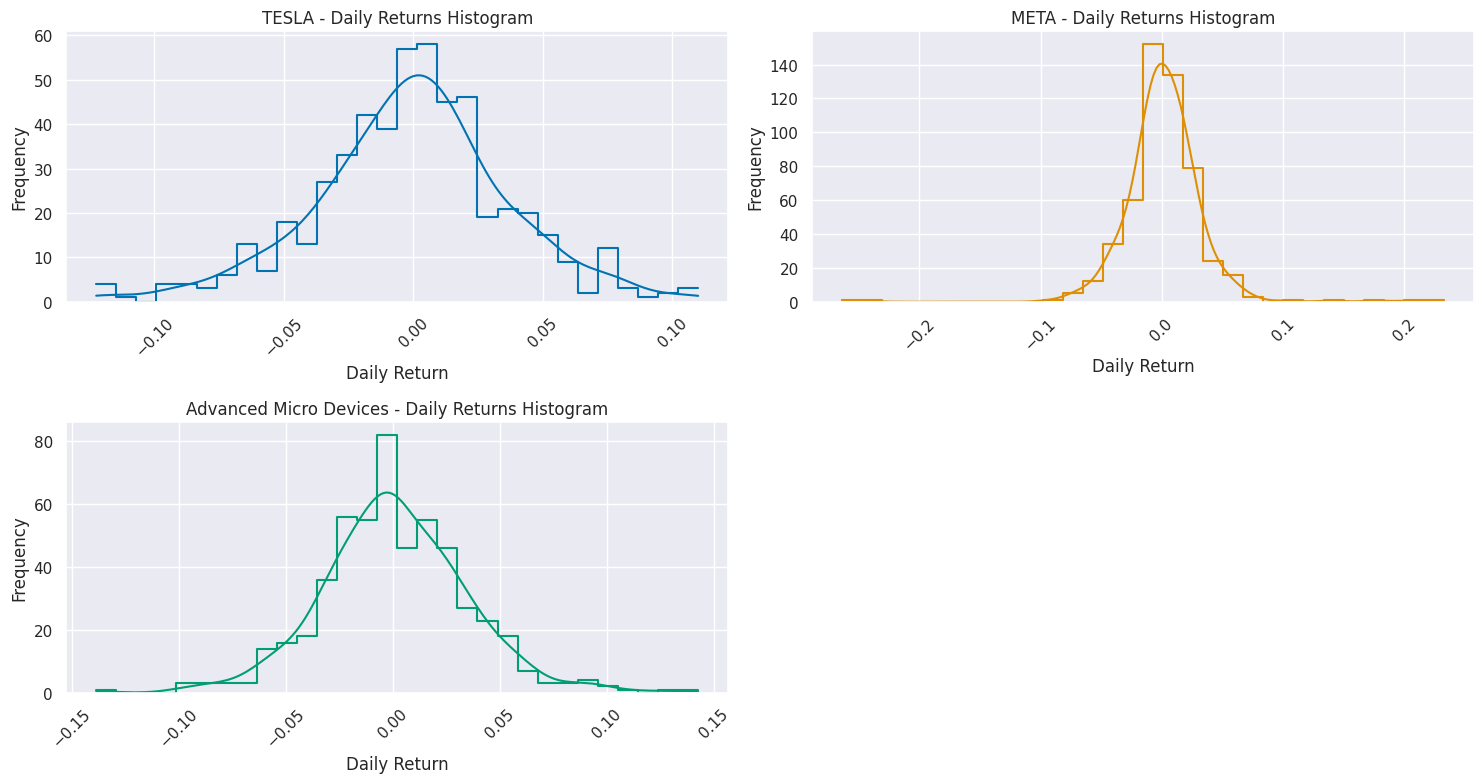

In [ ]:
# Graphs for  metric Daily Return for each company
plt.figure(figsize=(15, 8))  # Increase the figure height
plt.subplots_adjust(top=0.9, bottom=0.2, hspace=0.6, wspace=0.2)

for i, ticker in enumerate(tickers):
            plt.subplot(2, 2, i + 1)


            # Calculate daily returns for the current company
            returns_ticker = returns[ticker]
            sns.histplot(
                returns_ticker,
                bins=30,
                kde=True,
                element="step",
                fill=False,
                color=COLORBLIND_COLORS[i]
            )
            plt.title(f'{company_name[i]} - Daily Returns Histogram')
            plt.xlabel('Daily Return')
            plt.ylabel('Frequency')
        # Rotate x-axis labels to 45 degrees
            plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"Daily_Returns_histogram.png")
# Show the plot for each metric
plt.show()



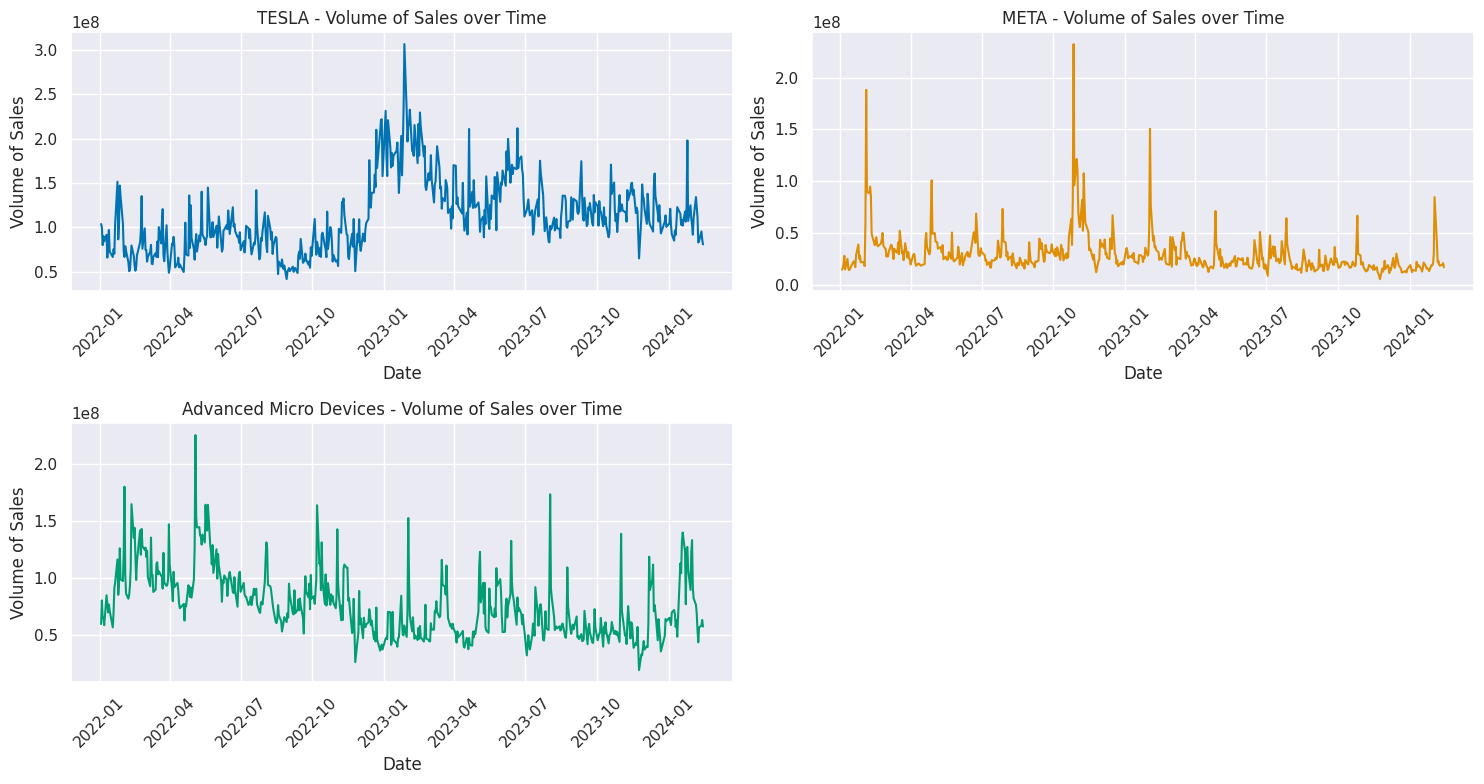

In [ ]:
# Separate graphs for metric Volume of sales
plt.figure(figsize=(15, 8))  # Increase the figure height
plt.subplots_adjust(top=0.9, bottom=0.2, hspace=0.6, wspace=0.2)

for i, ticker in enumerate(tickers):
            plt.subplot(2, 2, i + 1)
            # Plot the current metric for the current company
            sns.lineplot(
                x='Date',
                y='Volume',
                data=stock_prices_all[stock_prices_all['level_1'] == ticker],
                color=COLORBLIND_COLORS[i]
            )
            plt.title(f'{company_name[i]} - Volume of Sales over Time')
            plt.xlabel('Date')
            plt.ylabel('Volume of Sales')
        # Rotate x-axis labels to 45 degrees
            plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"Volume of Sales_histogram.png")
# Show the plot for each metric
plt.show()



Optimal portfolio weights are calculated through quadratic optimization

In [ ]:

# Ensure expected_returns is a 1D array
expected_returns = np.ravel(np.mean(returns, axis=0))

# Define risk tolerance
risk_tolerance = 0.1

# Define the optimization problem
weights = cp.Variable(len(tickers))
risk = cp.quad_form(weights, np.cov(returns, rowvar=False))
objective = cp.Maximize(expected_returns @ weights - risk_tolerance * risk)
constraints = [cp.sum(weights) == 1, weights >= 0]
problem = cp.Problem(objective, constraints)

problem.solve()

# Get the optimal weights
optimal_weights = weights.value

# Ensure optimal weights are non-negative
optimal_weights[optimal_weights < 0] = 0

# Print optimal weights for debugging
print("Optimal Weights:", optimal_weights)

Optimal Weights: [0. 1. 0.]


**Stock  Price:**The Stock price is the final price at which the stock was traded during the regular trading day. A stock's closing price is the usual benchmark that investors use to track its performance over time.

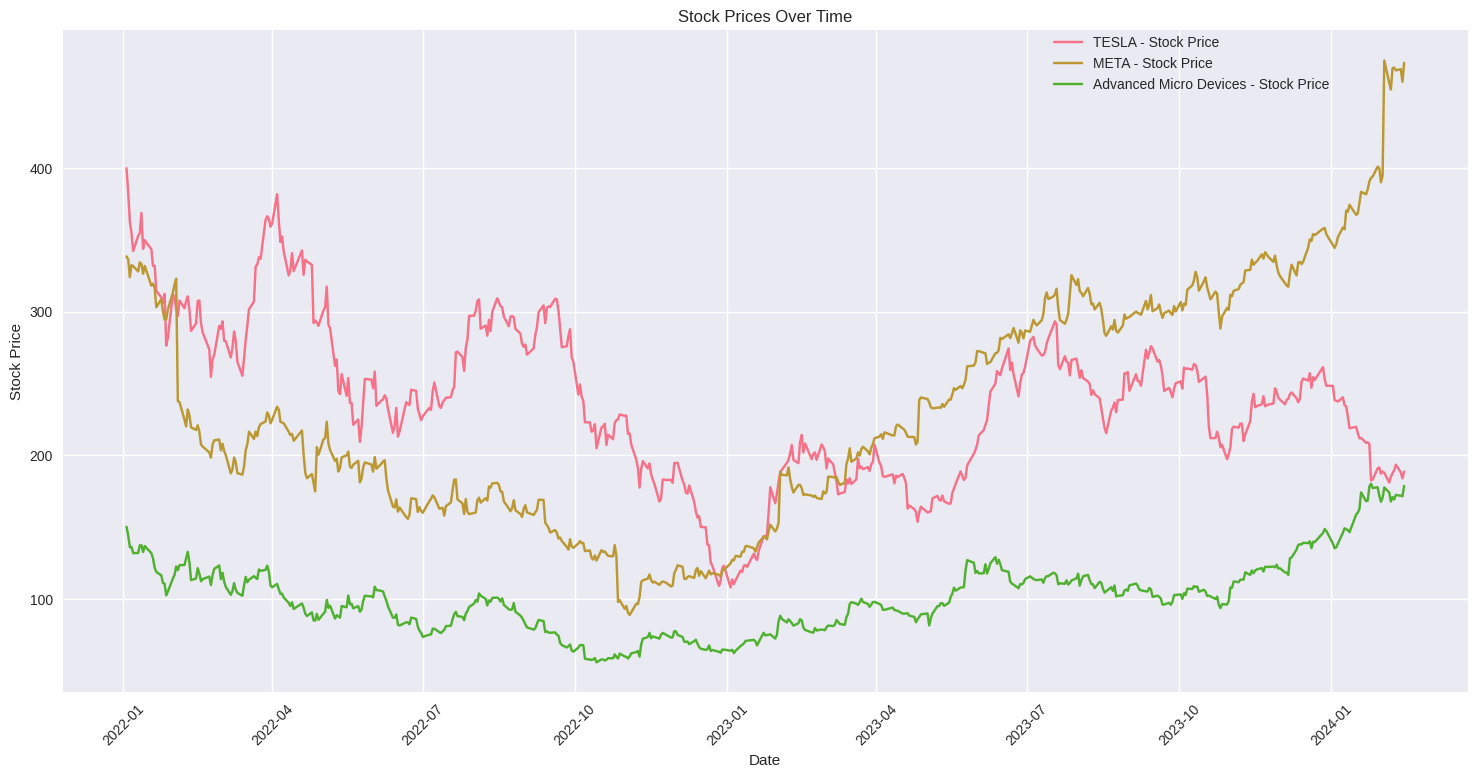

In [ ]:
# Plot stock prices over time using seaborn style
plt.figure(figsize=(15, 8))
sns.set_palette('husl')
for i, ticker in enumerate(tickers):
    sns.lineplot(x='Date', y='Adj Close', data=stock_prices_all[stock_prices_all['level_1'] == ticker], label=f'{company_name[i]} - Stock Price')
plot_graphs('Stock Prices Over Time','Date','Stock Price')


A straightforward technical analysis technique, the moving average (MA) establishes a continuously updated average price to smooth out price data. The average is calculated over a specified time frame, such as 30 days, 25 minutes, 40 weeks, or any other duration the trader selects.

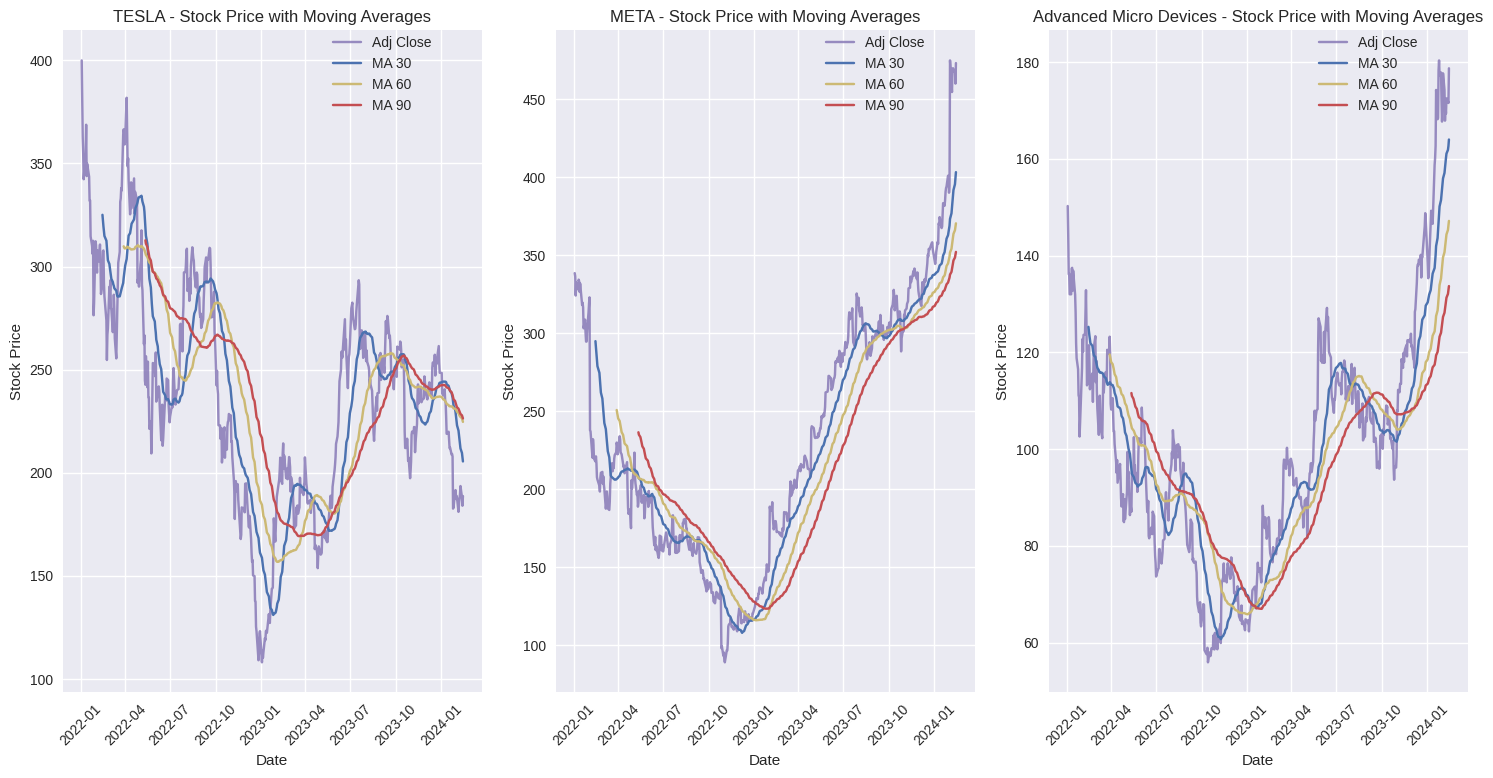

In [ ]:
# Create subplots with one row and three columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,8))
sns.set_palette('Dark2')
for i, ticker in enumerate(tickers):
    # Calculate Moving Averages
    ma_30 = stock_prices_all[stock_prices_all['level_1'] == ticker]['Adj Close'].rolling(window=30).mean()
    ma_60 = stock_prices_all[stock_prices_all['level_1'] == ticker]['Adj Close'].rolling(window=60).mean()
    ma_90 = stock_prices_all[stock_prices_all['level_1'] == ticker]['Adj Close'].rolling(window=90).mean()

    # Plot Adjusted Close
    axes[i].plot(stock_prices_all[stock_prices_all['level_1'] == ticker]['Date'],
                  stock_prices_all[stock_prices_all['level_1'] == ticker]['Adj Close'],
                  label='Adj Close', color='m', alpha=0.8)

    # Plot 30-day Moving Average
    axes[i].plot(stock_prices_all[stock_prices_all['level_1'] == ticker]['Date'], ma_30, label='MA 30', color='b')

    # Plot 60-day Moving Average
    axes[i].plot(stock_prices_all[stock_prices_all['level_1'] == ticker]['Date'], ma_60, label='MA 60', color='y')

    # Plot 90-day Moving Average
    axes[i].plot(stock_prices_all[stock_prices_all['level_1'] == ticker]['Date'], ma_90, label='MA 90', color='r')

    # Set y-label and title
    axes[i].set_ylabel('Stock Price')
    axes[i].set_title(f'{company_name[i]} - Stock Price with Moving Averages')
    axes[i].set_xlabel('Date')
    # Add legend on the right side
    axes[i].legend(loc='upper right', bbox_to_anchor=(0.91, 1.01))
    # Rotate x-axis labels to 45 degrees
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.savefig(f"Stock_Price_with_Moving_Averages.png")
plt.show()


**Relative Strength Index (RSI)** over time measures stock price changes to evaluate if it's overbought or oversold, aiding trend analysis.






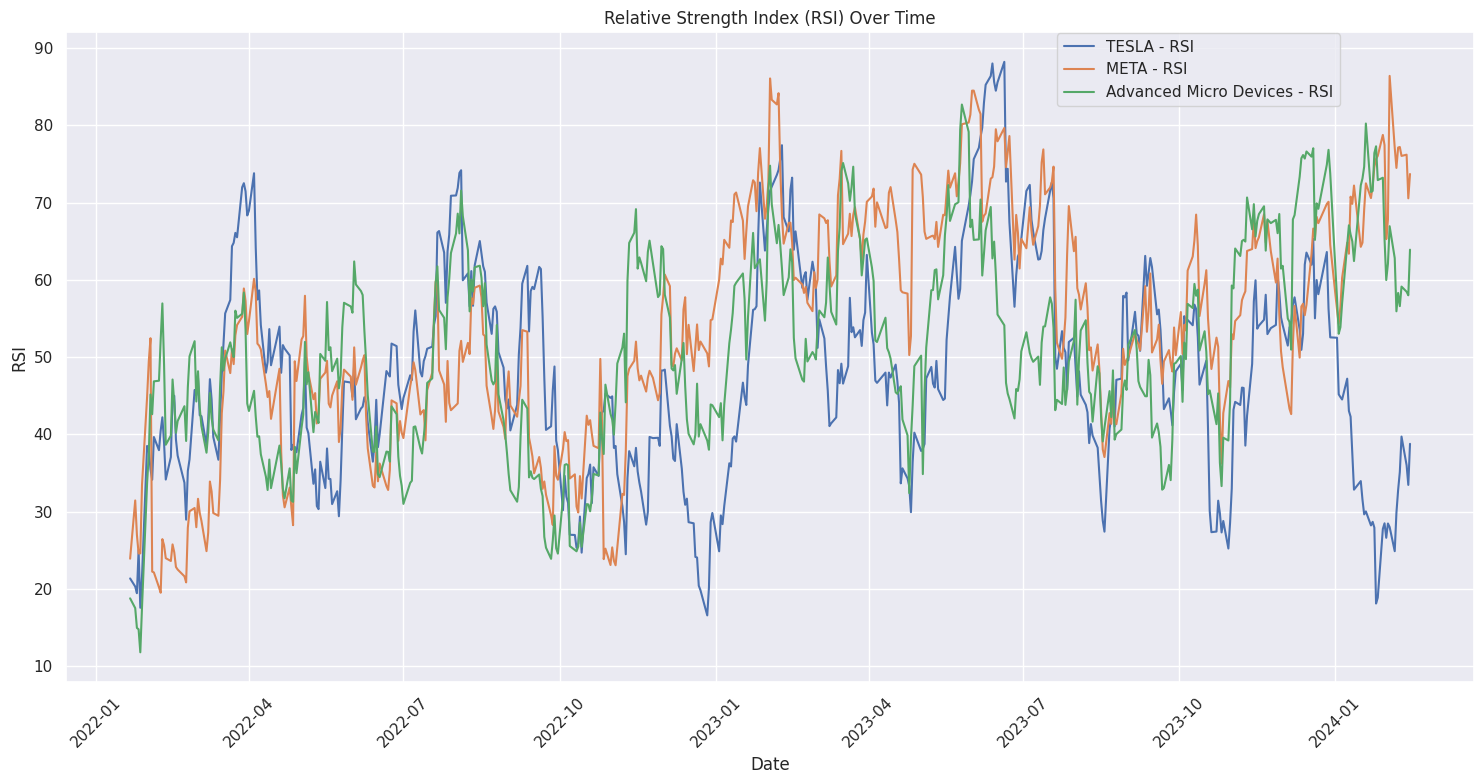

In [ ]:
# Plot Relative Strength Index (RSI) over time
plt.figure(figsize=(15, 8))
sns.set_palette('deep')
for i,ticker in enumerate(tickers):
    rsi = RSIIndicator(stock_prices_all[stock_prices_all['level_1'] == ticker]['Adj Close'])
    sns.lineplot(x=stock_prices_all[stock_prices_all['level_1'] == ticker]['Date'], y=rsi.rsi().values, label=f'{company_name[i]} - RSI')
plot_graphs('Relative Strength Index (RSI) Over Time','Date','RSI')




**Bollinger Bands** are a technical analysis tool that consists of a middle band being an N-period simple moving average and upper and lower bands representing volatility. They help identify potential overbought or oversold conditions in a market.






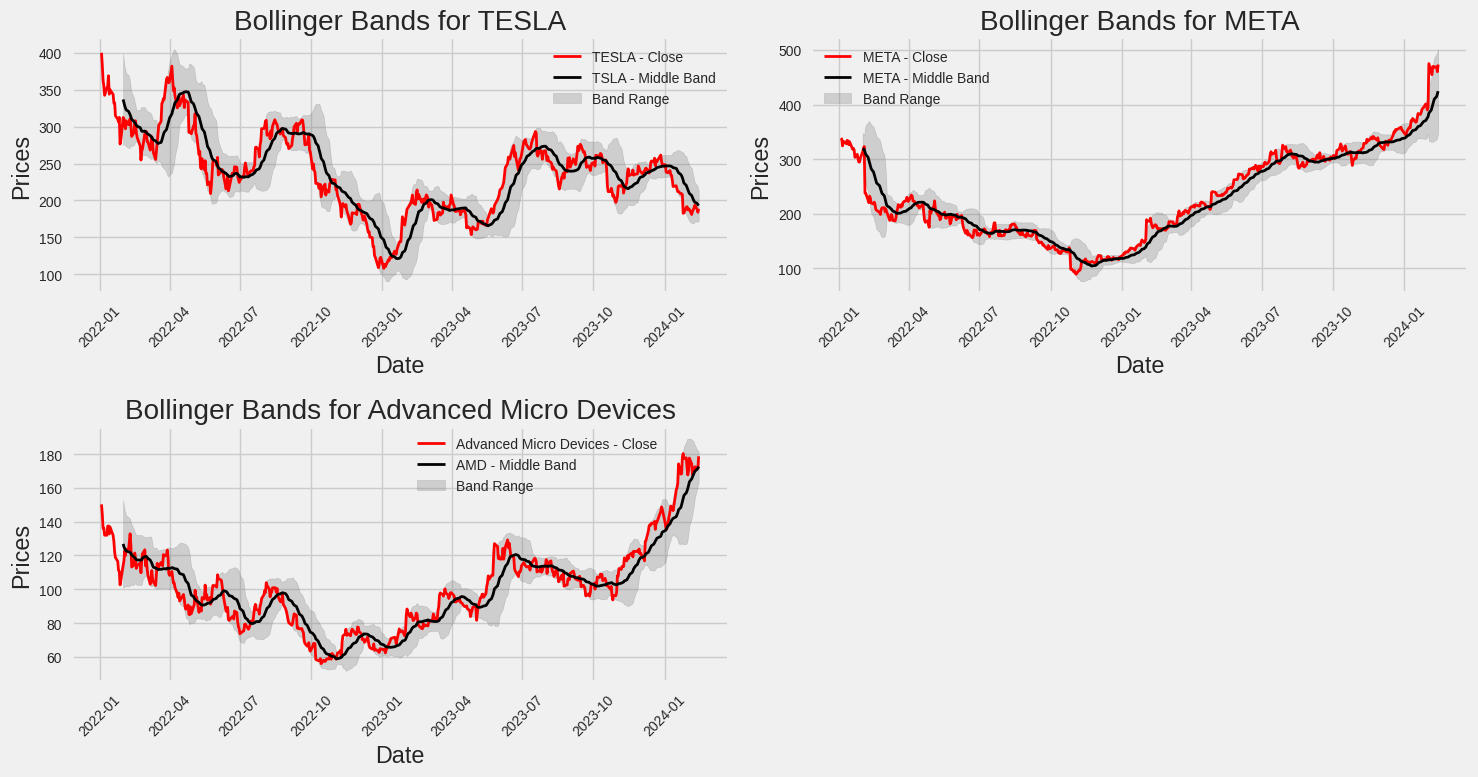

In [ ]:
plt.style.use('fivethirtyeight')

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

# Iterate through the tickers and corresponding subplots
for i, (ticker, ax) in enumerate(zip(tickers, axes.flatten())):
    bb = BollingerBands(stock_prices_all[stock_prices_all['level_1'] == ticker]['Adj Close'])

    # Plot Adjusted Closing Price
    ax.plot(stock_prices_all[stock_prices_all['level_1'] == ticker]['Date'], stock_prices_all[stock_prices_all['level_1'] == ticker]['Adj Close'], label=f'{company_name[i]} - Close', color='red', lw=2)

    # Plot Bollinger Bands
    ax.plot(stock_prices_all[stock_prices_all['level_1'] == ticker]['Date'], bb.bollinger_mavg().values, label=f'{ticker} - Middle Band', color='black', lw=2)
    ax.fill_between(stock_prices_all[stock_prices_all['level_1'] == ticker]['Date'], bb.bollinger_hband().values, bb.bollinger_lband().values, color='grey', label="Band Range", alpha=0.3)

    # Set title and labels
    ax.set_title(f'Bollinger Bands for {company_name[i]}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Prices')
    ax.legend()

    # Rotate x-axis labels to 45 degrees for better visibility
    ax.tick_params(axis='x', rotation=45)

# Remove the empty subplot in the last row
fig.delaxes(axes[1, 1])
plt.legend(loc='upper right', bbox_to_anchor=(0.91, 1.01))
# Adjust layout to move the third graph to the center
fig.subplots_adjust(top=0.9, bottom=0.2, hspace=0.6, wspace=0.2)
plt.tight_layout()  # Adjust the rect parameter to fit the title
plt.savefig(f"Bollinger_Bands.png")
# Show the plot
plt.show()



The Money Flow Index (MFI) is a momentum indicator that measures the inflow and outflow of money into and out of a stock over a specific period. It considers both price and volume, providing insights into potential overbought or oversold conditions in the market.


---



---


The Money Flow Index (MFI) is calculated using the following steps:

**Typical Price (TP)**: Calculate the typical price for each period, which is the average of high, low, and close prices **[(High + Low + Close) / 3]**.

**Money Flow (MF)**: Multiply the typical price by the corresponding period's volume to obtain the money flow [(Typical Price * Volume)] **bold text**.

**Positive Money Flow (PMF)** and ** Negative Money Flow (NMF)**: Sum the money flows for periods where the typical price is higher and lower than the previous period, respectively.

**Money Flow Ratio (MFR)**: Calculate the money flow ratio by dividing the PMF by NMF **[(PMF / NMF)]**.

**MFI Calculation**: Calculate the MFI using the formula **MFI = 100 - (100 / (1 + MFR)).**

The resulting MFI values range from 0 to 100, with readings above 70 indicating potential overbought conditions and readings below 30 suggesting potential oversold conditions.

<ipython-input-51-b2adfe78f8ed>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


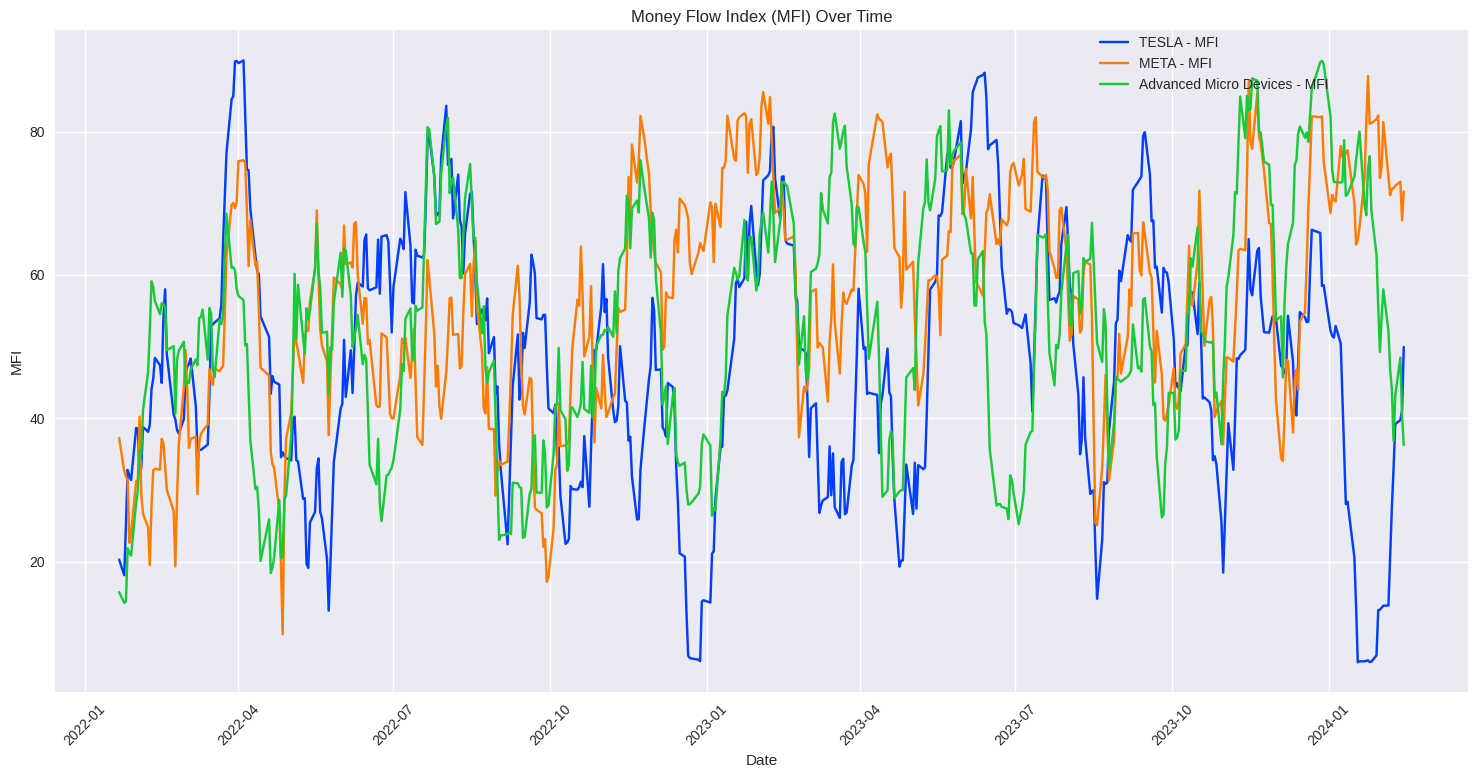

In [ ]:

plt.style.use('seaborn')

# Plot Money Flow Index (MFI) over time
plt.figure(figsize=(15, 8))
sns.set_palette('bright')
for i,ticker in enumerate(tickers):
    mfi = money_flow_index(stock_prices_all[stock_prices_all['level_1'] == ticker]['High'],
                           stock_prices_all[stock_prices_all['level_1'] == ticker]['Low'],
                           stock_prices_all[stock_prices_all['level_1'] == ticker]['Adj Close'],
                           stock_prices_all[stock_prices_all['level_1'] == ticker]['Volume'])
    sns.lineplot(x=stock_prices_all[stock_prices_all['level_1'] == ticker]['Date'], y=mfi.values, label=f'{company_name[i]} - MFI')

plot_graphs('Money Flow Index (MFI) Over Time','Date','MFI')


Sentiment analysis on financial news involves assessing the sentiment (positive, negative, neutral) of news articles using natural language processing. It helps investors gauge market sentiment, make informed decisions, and understand potential market impacts.

In [ ]:
# Sentiment analysis on financial news
news_sentiment = []

for i,ticker in enumerate(tickers):
    news = yf.Ticker(ticker).news

    # Check if 'news' is not empty and has the expected structure
    if news:
        for item in news:
            # Check for key 'summary' in the item
            if 'summary' in item and isinstance(item['summary'], str):
                combined_text = item['summary']
            elif 'title' in item and isinstance(item['title'], str):
                combined_text = item['title']
            else:
                print(f"No suitable text found for sentiment analysis in news item for {company_name[i]}.")
                continue

            # Perform sentiment analysis
            blob = TextBlob(combined_text)
            sentiment_score = blob.sentiment.polarity
            news_sentiment.append((ticker, datetime.utcfromtimestamp(item['providerPublishTime']), sentiment_score))

            # Print sentiment score for each news item
            print(f"Sentiment score for {company_name[i]} on {item['providerPublishTime']}: {sentiment_score:.2f}")
    else:
        print(f"No news available for {company_name[i]} for sentiment analysis.")

Sentiment score for TESLA on 1707985226: 0.00
Sentiment score for TESLA on 1707965739: 0.00
Sentiment score for TESLA on 1707959663: -0.16
Sentiment score for TESLA on 1707958263: 0.00
Sentiment score for TESLA on 1707955860: 0.00
Sentiment score for TESLA on 1707950340: -0.16
Sentiment score for TESLA on 1707948941: 0.00
Sentiment score for TESLA on 1707948000: 0.00
Sentiment score for META on 1707957051: 0.03
Sentiment score for META on 1707953077: -0.03
Sentiment score for META on 1707950962: 0.02
Sentiment score for META on 1707947945: 0.00
Sentiment score for META on 1707947770: 0.00
Sentiment score for META on 1707944700: 0.14
Sentiment score for META on 1707944700: 0.00
Sentiment score for META on 1707942042: 0.42
Sentiment score for Advanced Micro Devices on 1707987840: 0.16
Sentiment score for Advanced Micro Devices on 1707937845: 0.00
Sentiment score for Advanced Micro Devices on 1707904200: -0.60
Sentiment score for Advanced Micro Devices on 1707861125: 0.00
Sentiment score 

In [ ]:
# Convert news sentiment data to DataFrame for easier plotting
df_sentiment = pd.DataFrame(news_sentiment, columns=['Company', 'Date', 'Sentiment Score'])
# Convert 'Date' column to datetime
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'])
df_sentiment['Time'] = df_sentiment['Date'].dt.strftime('%I:%M %p')


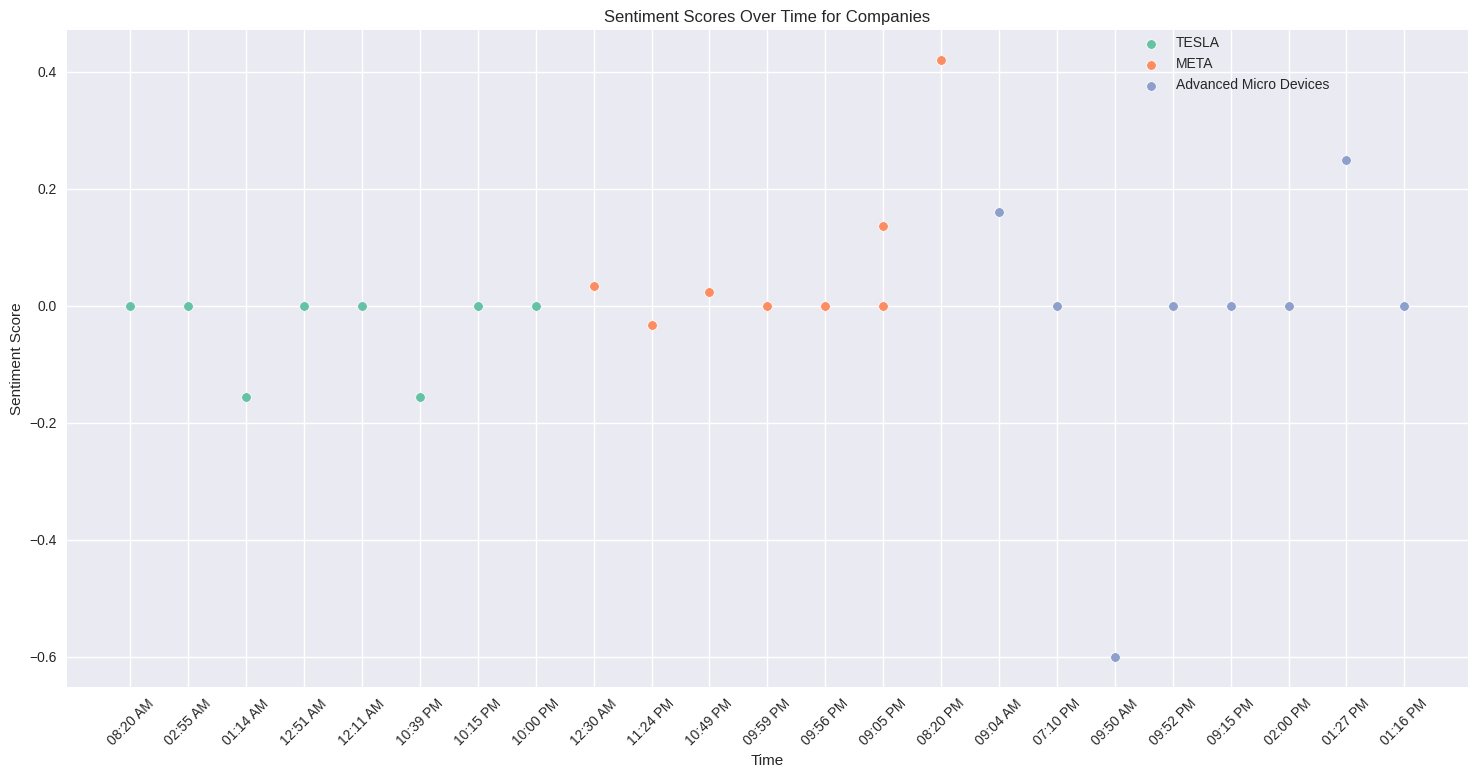

In [ ]:
# Plot sentiment scores over time using seaborn style
plt.figure(figsize=(15, 8))
sns.set_palette('Set2')

for i, company in enumerate(tickers):
    company_data = df_sentiment[df_sentiment['Company'] == company]
    sns.scatterplot(x=company_data['Time'], y=company_data['Sentiment Score'], label=company_name[i])

plot_graphs('Sentiment Scores Over Time for Companies','Time','Sentiment Score')


<b> EXPLORING CORRELATIONNS </B>

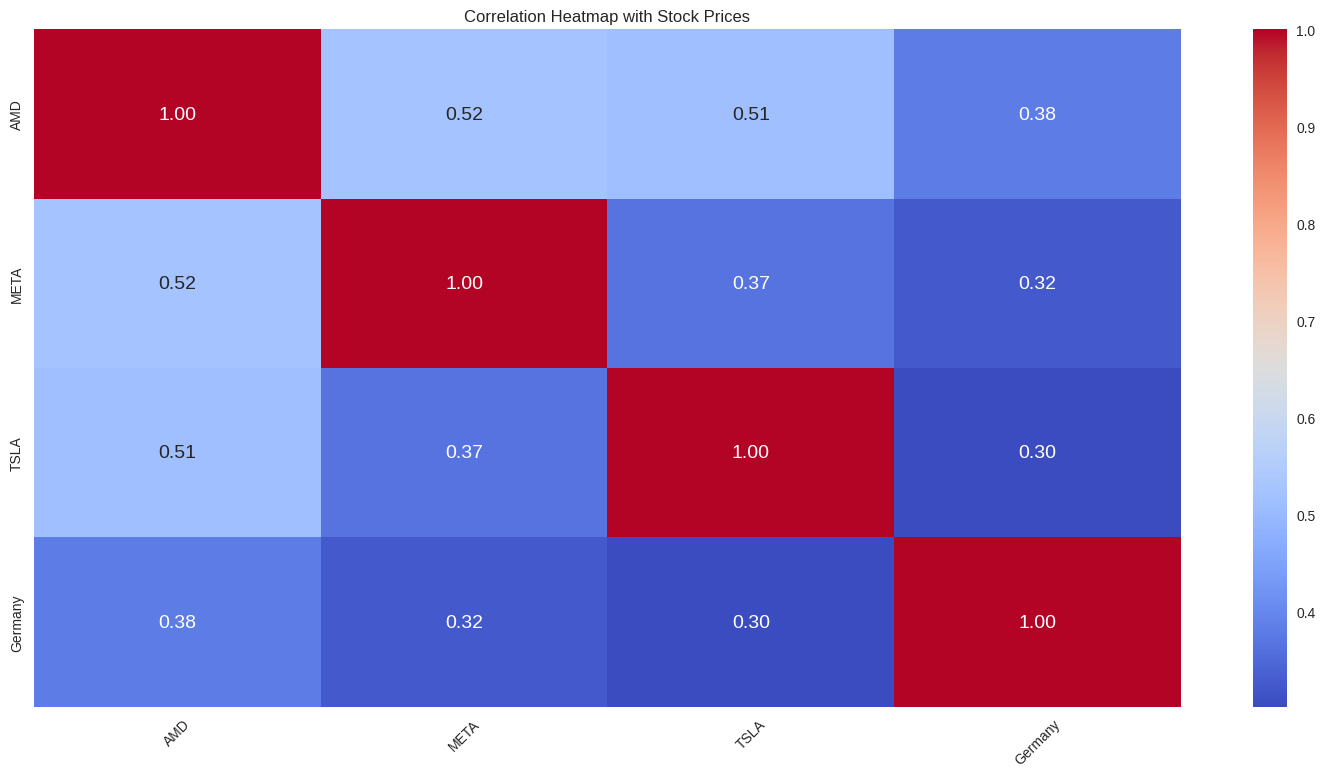

In [ ]:
# Calculate correlations with stock prices
correlations = returns.corr()

# Plot the correlation heatmap using seaborn style
plt.figure(figsize=(15, 8))
sns.set_palette('viridis')
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plot_graphs('Correlation Heatmap with Stock Prices','','')


The resulting heatmap allows you to identify patterns of positive and negative correlations, providing insights into how different variables move together or in opposite directions

<b> Transformation and Normalization </b>

Transformations are useful in preprocessing financial data for analysis, modeling, and comparison. They enhance the interpretability and statistical properties of the data, making it more suitable for various analytical techniques and machine learning models.



**Normalization**
Normalization is often applied to bring numerical features to a similar scale, usually between 0 and 1. This can be important for algorithms that rely on distances, such as k-Nearest Neighbors.


---


<b>Min-Max Normalization</b> is a suitable choice for this dataset, given that the features have varying ranges.

In [ ]:
# Log transformation of returns
log_returns = np.log(1 + returns)

# Standardization
standardized_returns = (log_returns - log_returns.mean()) / log_returns.std()

# Min-Max normalization
normalized_returns = (log_returns - log_returns.min()) / (log_returns.max() - log_returns.min())

# Display the modified DataFrames
print("Original Returns DataFrame:")
print(returns.head())
print("\nLog-transformed Returns DataFrame:")
print(log_returns.head())
print("\nStandardized Returns DataFrame:")
print(standardized_returns.head())
print("\nNormalized Returns DataFrame:")
print(normalized_returns.head())

Original Returns DataFrame:
level_1          AMD      META      TSLA
Date                                    
2022-01-04 -0.038738 -0.005937 -0.041833
2022-01-05 -0.057264 -0.036728 -0.053471
2022-01-06  0.000588  0.025573 -0.021523
2022-01-07 -0.031050 -0.002015 -0.035447
2022-01-10  0.000000 -0.011212  0.030342

Log-transformed Returns DataFrame:
level_1          AMD      META      TSLA
Date                                    
2022-01-04 -0.039508 -0.005955 -0.042733
2022-01-05 -0.058969 -0.037419 -0.054954
2022-01-06  0.000587  0.025251 -0.021758
2022-01-07 -0.031543 -0.002017 -0.036090
2022-01-10  0.000000 -0.011275  0.029891

Standardized Returns DataFrame:
level_1          AMD      META      TSLA
Date                                    
2022-01-04 -1.158304 -0.188392 -1.090500
2022-01-05 -1.724124 -1.087775 -1.413129
2022-01-06  0.007509  0.703622 -0.536785
2022-01-07 -0.926697 -0.075835 -0.915133
2022-01-10 -0.009571 -0.340468  0.826723

Normalized Returns DataFrame:
level_1    

Prediction using Deep Learning Model based on specific country.
In this example it is Country consider is Germany. Model is trained accordingly.

In [ ]:
# Add 'Germany' to the daily returns DataFrame
returns['Germany'] = germany_data['Adj Close'].pct_change().dropna()

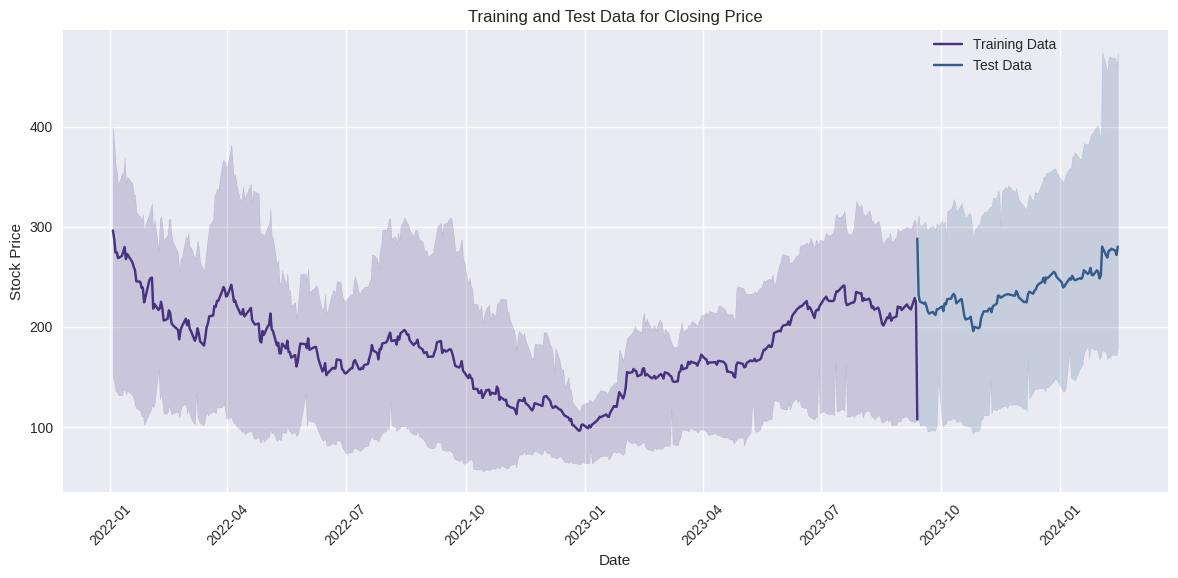

In [ ]:
# Add 'Germany' to the daily returns DataFrame
returns['Germany'] = germany_data['Adj Close'].pct_change().dropna()

# Prepare the features (X) and target variable (y) for the model
X = returns[['TSLA', 'META', 'AMD', 'Germany']].values
y = returns['TSLA'].values  # Predicting Apple's stock returns

train_size = int(len(stock_prices_all) * 0.8)

train_data = stock_prices_all[:train_size]
test_data = stock_prices_all[train_size:]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Visualize the training and test data
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Adj Close', data=train_data, label='Training Data')
sns.lineplot(x='Date', y='Adj Close', data=test_data, label='Test Data')
plot_graphs(
    'Training and Test Data for Closing Price',
    'Date',
    'Stock Price'
)

In [ ]:
# Standardize the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [ ]:

# Define the neural network model
class StockPredictor(nn.Module):
    """
    StockPredictor is a neural network model for stock prediction.

    Args:
        input_size (int): The size of the input features.

    Attributes:
        fc1 (nn.Linear): The first fully connected layer.
        relu (nn.ReLU): The ReLU activation function.
        fc2 (nn.Linear): The second fully connected layer.

    Methods:
        forward(x): Performs forward pass through the network.

    """

    def __init__(self, input_size):
        super(StockPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        """
        Performs forward pass through the neural network.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


# Instantiate the model
input_size = X_train_tensor.shape[1]
model = StockPredictor(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Model Training with 1000 epochs

In [ ]:

# Train the model
for epoch in range(NUM_EPOCHS):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)


Epoch [100/1000], Loss: 0.0006
Epoch [200/1000], Loss: 0.0003
Epoch [300/1000], Loss: 0.0002
Epoch [400/1000], Loss: 0.0001
Epoch [500/1000], Loss: 0.0001
Epoch [600/1000], Loss: 0.0001
Epoch [700/1000], Loss: 0.0001
Epoch [800/1000], Loss: 0.0001
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000


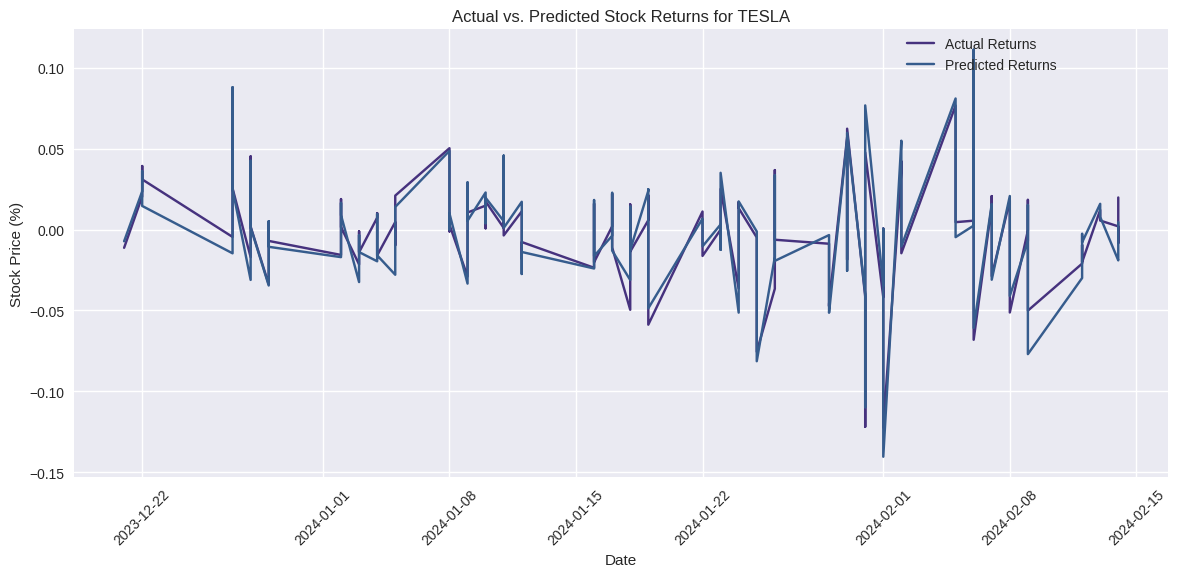

In [ ]:
common_length = min(len(test_data), len(y_test), len(test_predictions.numpy().flatten()))

# Slice the arrays to the common length
test_data_slice = test_data.iloc[-common_length:]

# Create the DataFrame
results = pd.DataFrame({
    'Date': test_data_slice['Date'].values,
    'Actual Returns': y_test[:common_length],
    'Predicted Returns': test_predictions.numpy().flatten()[:common_length],
    'Adj Close': test_data_slice['Adj Close'].values
})


plt.figure(figsize=(12, 6))
plt.plot(results['Date'],y_test, label='Actual Returns')
plt.plot(results['Date'],test_predictions.numpy(), label='Predicted Returns')
plot_graphs(
    'Actual vs. Predicted Stock Returns for TESLA',
    'Date',
    'Stock Price (%)'
)

**Prediction Model Accuracy Analysis**
To assess the accuracy of our forecast model, we can compare the forecasted values with the actual values. This can be done by using some measures such as **Mean Absolute Error (MAE)**, **Mean Squared Error (MSE)**, or **Root Mean Squared Error (RMSE)**

In [ ]:

# Calculate Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE)
mae = mean_absolute_error(y_test, test_predictions.numpy())
mse = mean_squared_error(y_test, test_predictions.numpy())
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 0.00679905226578378
Mean Squared Error (MSE): 9.062358150250477e-05
Root Mean Squared Error (RMSE): 0.009519641878899898


In [ ]:
# Flatten the arrays
test_predictions_flat = test_predictions.numpy().flatten()

y_test_flat = y_test.flatten()

**Analysis of volatility**:
Determines the extent to which risk is involved in forecasting by computing the rates of uncertainty based on past and future figures. Variability measures like standard deviation or average true range can show the steadiness and dependability of these predictions.

Actual Volatility: 0.0343228146647634
Predicted Volatility: 0.03650737


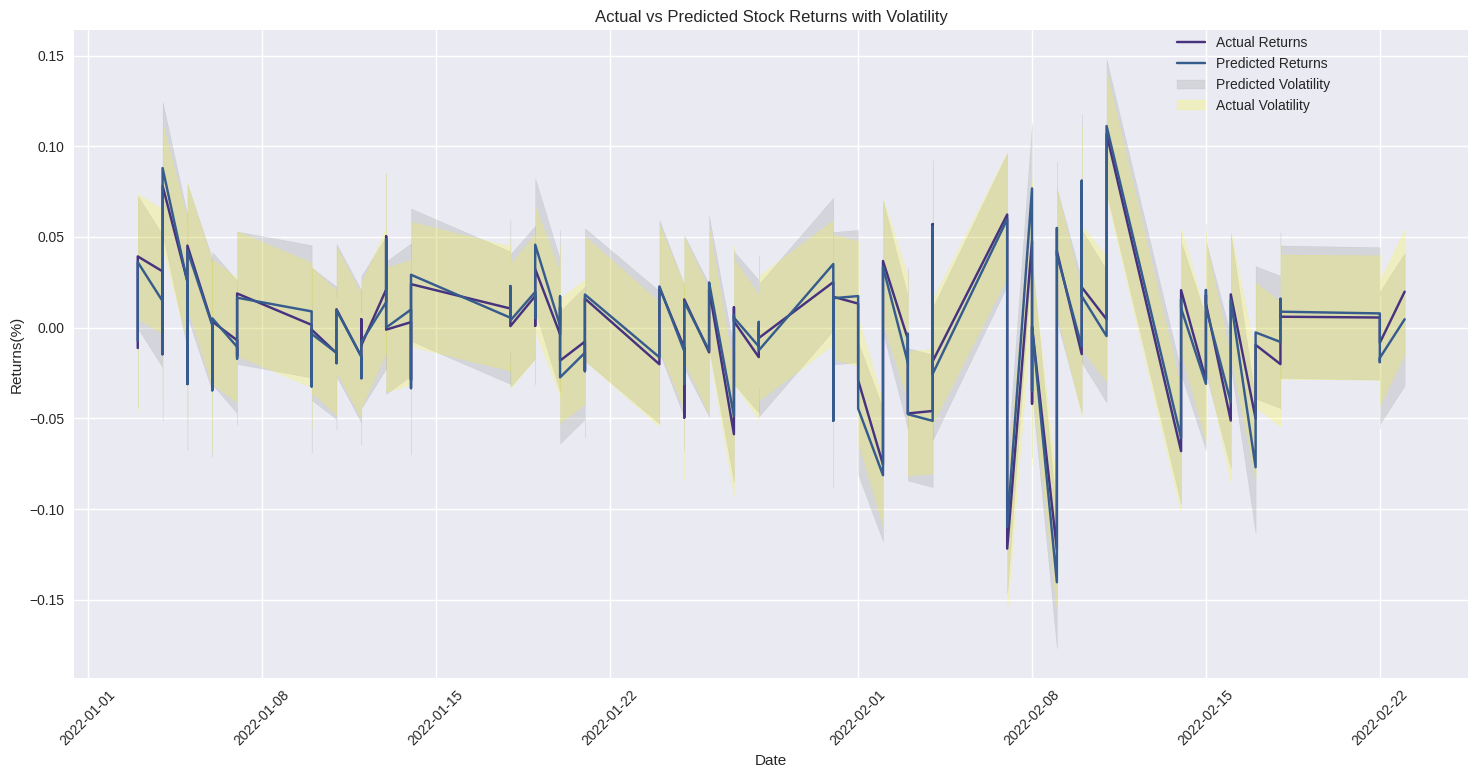

In [ ]:

# Calculate volatility of actual and predicted returns
actual_volatility = np.std(y_test_flat)
predicted_volatility = np.std(test_predictions_flat)

print("Actual Volatility:", actual_volatility)
print("Predicted Volatility:", predicted_volatility)

date_values = stock_prices_all['Date']

# Truncate 'date_values' to match the length of 'y_test_flat'
date_values = date_values[:len(y_test_flat)]

# Plot the actual vs predicted graph with volatility
plt.figure(figsize=(15, 8))
plt.plot(date_values, y_test_flat, label='Actual Returns')
plt.plot(date_values, test_predictions_flat, label='Predicted Returns')
plt.fill_between(date_values, test_predictions_flat - predicted_volatility, test_predictions_flat + predicted_volatility, color='gray', alpha=0.2, label='Predicted Volatility')
plt.fill_between(date_values, y_test_flat - actual_volatility, y_test_flat + actual_volatility, color='yellow', alpha=0.2, label='Actual Volatility')
plot_graphs('Actual vs Predicted Stock Returns with Volatility', 'Date', 'Returns(%)')



**Evaluation of Trading Strategies:**
The actual as well as forecasted data is used to analyze how different trading strategies have performed. To assess the workability of these strategies, simulation trades should be backtested based on such predictions with profitability and risk statistics as some of the tools used in assessing their performance.

In [ ]:
# Simulate trades based on the predicted returns using the simple trading strategy
test_trades = simple_trading_strategy(test_predictions.numpy())

# Calculate the returns based on the simulated trades
test_returns = test_trades * y_test

In [ ]:
# Calculate profitability and risk metrics
total_trades = len(test_trades)
positive_trades = np.sum(test_trades[test_trades > 0])
negative_trades = total_trades - positive_trades
win_ratio = positive_trades / total_trades
profit_factor = np.sum(test_returns[test_returns > 0]) / np.abs(np.sum(test_returns[test_returns < 0]))
cumulative_returns = np.cumsum(test_returns)
max_drawdown = np.max(np.maximum.accumulate(cumulative_returns) - cumulative_returns)
sharpe_ratio = np.mean(test_returns) / np.std(test_returns)


In [ ]:

# Print metrics
print("Total Trades:", total_trades)
print("Positive Trades:", positive_trades)
print("Negative Trades:", negative_trades)
print("Win Ratio:", win_ratio)
print("Profit Factor:", profit_factor)
print("Max Drawdown:", max_drawdown)
print("Sharpe Ratio:", sharpe_ratio)


Total Trades: 106
Positive Trades: 55
Negative Trades: 51
Win Ratio: 0.5188679245283019
Profit Factor: 0.9981767722333439
Max Drawdown: 1.3251413571453803
Sharpe Ratio: -0.0006457575381407996


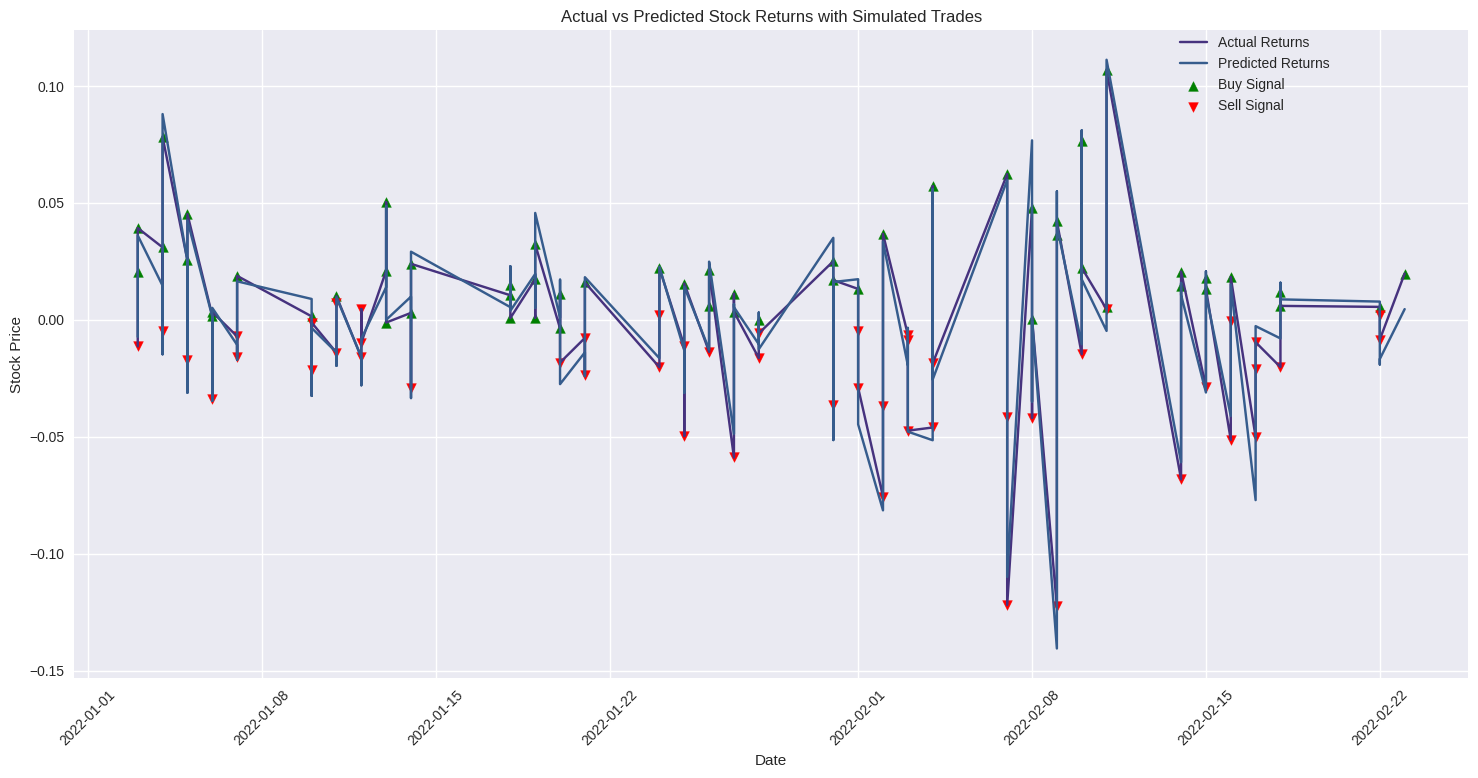

In [ ]:

plt.figure(num="Actual vs Predicted with Simulated Trades", figsize=(15, 8))  # Specify a unique identifier for the figure


date_values = stock_prices_all['Date']

# Ensure that 'y_test', 'test_predictions', and 'test_trades' have the same length
assert len(y_test) == len(test_predictions) == len(test_trades), "Lengths of arrays must match"

# Plot actual and predicted returns
plt.plot(date_values[:len(y_test)], y_test, label='Actual Returns')  # Truncate date_values to match the length of y_test
plt.plot(date_values[:len(test_predictions)], test_predictions.numpy(), label='Predicted Returns')

# Plot buy signals
buy_indices = np.where(test_trades == 1)[0]
plt.scatter(date_values[buy_indices], y_test[buy_indices], color='green', marker='^', label='Buy Signal')

# Plot sell signals
sell_indices = np.where(test_trades == -1)[0]
plt.scatter(date_values[sell_indices], y_test[sell_indices], color='red', marker='v', label='Sell Signal')

# Assuming a function plot_graphs(xlabel, ylabel, title) is defined
plot_graphs(
    'Actual vs Predicted Stock Returns with Simulated Trades',
    'Date',
    'Stock Price'
)
